## K-Shape Clustering

### Issues

1. Even though clusters stay the same, rerunning the model causes the centroids to change, also changing the inter and intracluster
computation

In [12]:
import warnings
warnings.filterwarnings("ignore")

from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.spatial.distance as dist
from pandas_datareader import data as pdr
import yfinance as yfin
import tslearn
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape

#### Test on some financial time series


In [13]:
# Download data sample
tickers = ["BTC-USD", "ETH-USD", "GOOG", "MSFT", "LINK-USD", "AAPL", "NFLX", "WMT", "KO", "PEP",
           "TSM", "INTC", "AMD","NVDA", "TSLA", "META", "SPY", "^DJI", "^IXIC", "GOLD", "JPM",
            "WFC", "GS" ]
start_date = "2020-01-01"
end_date = "2022-12-31"

yfin.pdr_override()

fin_data = []
for i in tickers:
    data = pdr.get_data_yahoo(i, start=start_date, end=end_date, interval="1wk")['Close']
    fin_data.append(np.array([[x] for x in data]))

fin_data = np.array(fin_data)

## UNCOMMENT TO DOWNLOAD FULL DATASET
# btc_data = pdr.get_data_yahoo(tickers[0],  start=start_date, end=end_date, interval = "1wk")
# eth_data = pdr.get_data_yahoo(tickers[1],  start=start_date, end=end_date, interval = "1wk")
# goog_data = pdr.get_data_yahoo(tickers[2],  start=start_date, end=end_date, interval = "1wk")
# msft_data = pdr.get_data_yahoo(tickers[3],  start=start_date, end=end_date, interval = "1wk")

# Normalize data
X = fin_data
scaler = TimeSeriesScalerMeanVariance()
X = scaler.fit_transform(X)

# Save close data
btc_close = fin_data[0,:,:]
eth_close = fin_data[1,:,:]
goog_close = fin_data[2,:,:]
plnt_close = fin_data[7,:,:]
ko_close = fin_data[8,:,:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [14]:
# # Initialize parameters for cluster
# n_clusters = 4

# # Compute model
# model = KShape(n_clusters = n_clusters, verbose = False, n_init=15)
# model.fit(X)
# result = model.fit_predict(X)


In [15]:
# sz = X.shape[1]

# plt.figure()
# for yi in range(n_clusters):
#     plt.subplot(n_clusters, 1, 1 + yi)
#     for xx in X[result == yi]:
#         plt.plot(xx.ravel(), "k-", alpha=.2)
#     plt.xlim(0, sz)
#     plt.ylim(-4, 4)
#     plt.title("Cluster %d" % (yi + 1))

# plt.tight_layout()
# plt.show()

# for y in range(len(tickers)):
#     print(tickers[y] + ' is in cluster ' + str(result[y] + 1))

Clustering looks good once the number of clusters is knwon in advance. Implement the Silhouette metric in order to identifie the number of clusters.
To do so, build the framework to compute intra and inter-cluster distance thorugh SBD.


0.10507016969792682


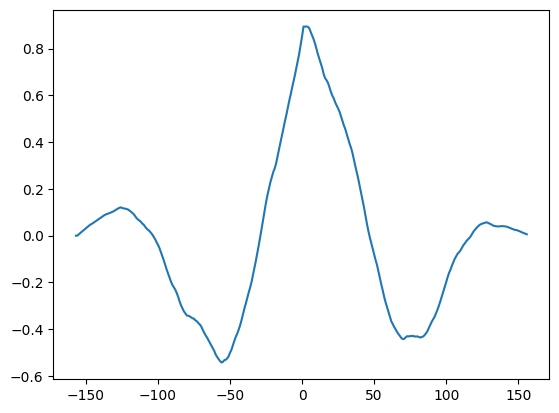

In [16]:
# Define functions to compute distance

def ncc(x:pd.DataFrame, y:pd.DataFrame):
    '''Returns the normalized autocorrelation coeffiencent between two time series
    given all possible shifts'''
    autocorr = []
    normalizer = float(np.sqrt(np.dot(x.transpose(), x)*np.dot(y.transpose(), y)))
    for i in range(2*len(x)):
        shifted = np.nan_to_num(x.shift(-len(x)-1+i), copy = False)
        autocorr.append(np.dot(shifted.transpose(), y)[0][0]/normalizer)
    return autocorr


def sbd(x:pd.DataFrame, y:pd.DataFrame):
    '''Returns the Shape-based Distance between two time series according to the Gravano and
    Paparrizos (2015) definition using the normalized cross correlation coefficient'''
    autocorr = ncc(x,y)
    normalizer = float(np.sqrt(np.dot(x.transpose(), x)*np.dot(y.transpose(), y)))
    shift_opt = np.argmax(autocorr)-len(btc)
    shifted = np.nan_to_num(x.shift(shift_opt-1), copy = False)
    res = 1 - autocorr[np.argmax(autocorr)]
    return 1 - np.dot(shifted.transpose(), y)[0][0]/normalizer

btc = pd.DataFrame({'val': [float(x) for x in X[0]]})
eth = pd.DataFrame({'val': [float(x) for x in X[1]]})

autocorr = ncc(btc,eth)
start = len(btc)

# Plot the autocorrelation vector
plt.plot(np.arange(-len(btc),len(btc)),autocorr)

print(sbd(btc,eth))

#### Plot Silhouette to determine optimal number of clusters


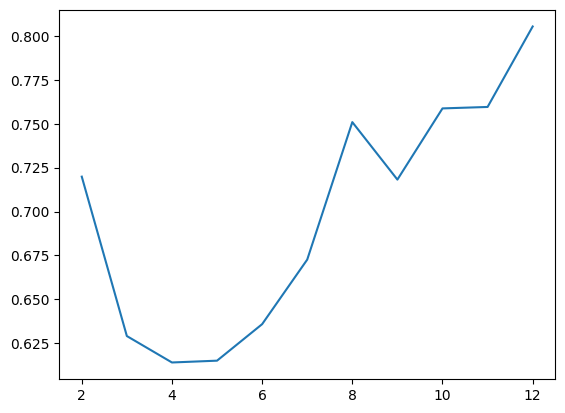

In [34]:
# Inter-cluster distance
start_clust = 2
end_clust = int(round(X.shape[0]/2))
inter_dist = []
intra_dist = []
for n_clusters in range(start_clust,end_clust+1):
    #print('#----------------------------------#')
    #print('#------- Test for {n} clusters ------#'.format(n = n_clusters))
    #print('#----------------------------------#')
    model = KShape(n_clusters = n_clusters, verbose = False, n_init=100, random_state = 0)
    model.fit(X)
    result = model.fit_predict(X)
    inter_clst_distance = []
    for clst in range(n_clusters):
        series = []
        centroid = pd.DataFrame({'centroid': [float(i) for i in model.cluster_centers_[clst]]})
        indices = [x for x in range(len(tickers)) if result[x] == clst]
        for index in indices:
            series.append(X[index])
        series = np.array(series)
        for serie in series:
            serie = pd.DataFrame({'serie' : [float(i) for i in serie]})
            dist = sbd(serie,centroid)
            inter_clst_distance.append(dist)
            #print("Inter-cluster distance for cluster " + str(clst+1) + " is " + str(inter_clst_distance))
    inter_dist.append(np.mean(np.array(inter_clst_distance)))
    intra_clust_dist = []
    for i in range(X.shape[0]):
        serie = X[i,:,:]
        b_clust = result[i]
        o_clust = [x for x in range(n_clusters) if x != b_clust]
        #print('### Processing series {n} ###'.format(n = i))
        dist = []
        for clst in o_clust:
            dist.append(sbd(pd.DataFrame({'Serie': [float(x) for x in serie]}), pd.DataFrame({'centroid': [float(x) for x in model.cluster_centers_[clst]]})))
        intra_clust_dist.append(min(dist))
    intra_dist.append(np.mean(np.array(intra_clust_dist)))
silhouette = []
for j in range(len(intra_dist)):
    silhouette.append((intra_dist[j] - inter_dist[j])/max(intra_dist[j], inter_dist[j]))
plt.plot(np.arange(start_clust,end_clust+1), silhouette)
# plt.plot(np.arange(start_clust,end_clust+1), inter_dist)

In [18]:
a = np.mean(np.array(inter_dist))
print(inter_dist[3])

0.0791794145813556


#### Second step is to compute inter-cluster distance

In [37]:
# start_clust = 2
# end_clust = 10
# intra_dist = []
# for value in range(start_clust,end_clust+1):
#     n_clusters = value
#     model = KShape(n_clusters = n_clusters, verbose = False, n_init=30)
#     model.fit(X)
#     result = model.fit_predict(X)
#     intra_clust_dist = []
#     for i in range(X.shape[0]):
#         serie = X[i,:,:]
#         b_clust = result[i]
#         o_clust = [x for x in range(n_clusters) if x != b_clust]
#         print('### Processing series {n} ###'.format(n = i))
#         dist = []
#         print(b_clust)
#         for clst in o_clust:
#             dist.append(sbd(pd.DataFrame({'Serie': [float(x) for x in serie]}), pd.DataFrame({'centroid': [float(x) for x in model.cluster_centers_[clst]]})))
#         intra_clust_dist.append(min(dist))
#     intra_dist.append(np.mean(np.array(intra_clust_dist)))
# plt.plot(np.arange(start_clust,end_clust+1), intra_dist)

In [31]:
# # Plot the silhouette
# silhouette = []
# for j in range(len(intra_dist)):
#     silhouette.append((intra_dist[j] - inter_dist[j])/max(intra_dist[j], inter_dist[j]))
# plt.plot(np.arange(start_clust,end_clust+1), silhouette)

8

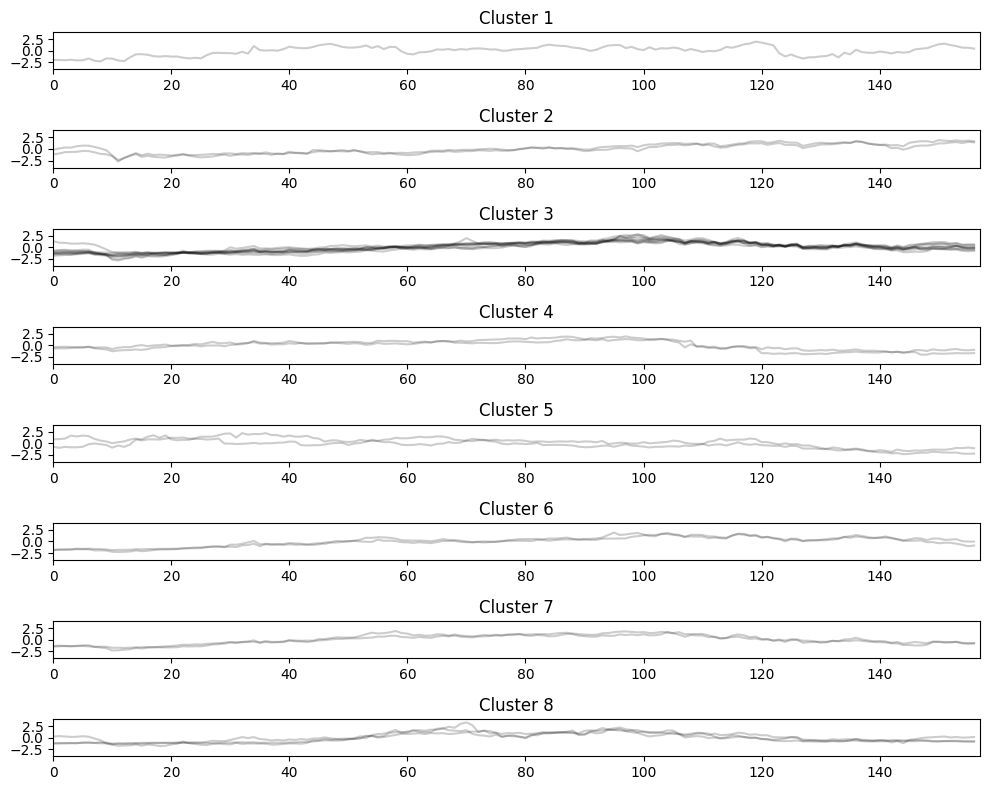

BTC-USD is in cluster 8
ETH-USD is in cluster 3
GOOG is in cluster 3
MSFT is in cluster 3
LINK-USD is in cluster 8
AAPL is in cluster 6
NFLX is in cluster 4
WMT is in cluster 1
KO is in cluster 2
PEP is in cluster 2
TSM is in cluster 7
INTC is in cluster 5
AMD is in cluster 3
NVDA is in cluster 3
TSLA is in cluster 6
META is in cluster 4
SPY is in cluster 3
^DJI is in cluster 3
^IXIC is in cluster 7
GOLD is in cluster 5
JPM is in cluster 8
WFC is in cluster 3
GS is in cluster 3


In [38]:
# Insert optimal number of clusters
# n_clusters = np.argmax(silhouette) + 2
n_clusters = 8

# Compute model
model = KShape(n_clusters = n_clusters, verbose = False, n_init=30, random_state = 0)
model.fit(X)
result = model.fit_predict(X)

# Print result
sz = X.shape[1]

plt.figure(figsize=(10,8))
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, 1 + yi)
    for xx in X[result == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

for y in range(len(tickers)):
    print(tickers[y] + ' is in cluster ' + str(result[y] + 1))

In [ ]:
import numpy as np

def k_shape_clustering(X, K, n_init=10, max_iter=100):
    """
    K Shape Clustering algorithm implementation using normalized cross-correlation
    coefficient as the distance measure between time series.
    
    Parameters:
    -----------
    X : ndarray
        The input data as a N-dimensional array of shape (n_samples, n_features).
    K : int
        The number of clusters to create.
    n_init : int, optional (default=10)
        The number of times the algorithm will be run with different centroid initializations.
    max_iter : int, optional (default=100)
        The maximum number of iterations to run for each centroid initialization.
        
    Returns:
    --------
    labels : ndarray
        The cluster labels assigned to each input sample.
    centroids : ndarray
        The final centroid values of each cluster.
    """
    
    # Initialization
    n_samples, n_features = X.shape
    best_labels = None
    best_inertia = np.inf
    for i_init in range(n_init):
        # Initialize centroids randomly
        centroids = np.random.rand(K, n_features)
        for i_iter in range(max_iter):
            # Compute the normalized cross-correlation between each sample and each centroid
            distances = np.zeros((n_samples, K))
            for k in range(K):
                for i in range(n_samples):
                    corr = np.correlate(X[i], centroids[k], mode='valid')
                    distances[i, k] = 1 - corr / (np.sqrt(np.sum(X[i]**2)) * np.sqrt(np.sum(centroids[k]**2)))
            
            # Assign each sample to the closest centroid
            labels = np.argmin(distances, axis=1)
            
            # Compute the inertia of the current configuration
            inertia = np.sum(distances[np.arange(n_samples), labels]**2)
            
            # Update the centroids as the mean of the samples in each cluster
            for k in range(K):
                centroids[k] = np.mean(X[labels == k], axis=0)
            
            # Check if the algorithm converged to a better solution
            if inertia < best_inertia:
                best_inertia = inertia
                best_labels = labels.copy()
                best_centroids = centroids.copy()
                
    return best_labels, best_centroids